In [4]:
import os

import copy

import pickle

import time

import numpy as np
import pandas as pd

import sys
sys.path.append(r'../')

from utils.WilmanDB import *
from utils.spectrum import *
from utils.methods import skymodel_to_img
from utils.methods import check_mem
import utils.methods as mthd
from utils.functions import in_FoV


from utils.galaxy import RSgen

import matplotlib.pyplot as plt


from astropy import convolution
from astropy.io import fits as fits
import astropy.units as u
from radio_beam import Beam

from scipy.ndimage.interpolation import shift
from scipy.signal import fftconvolve

from joblib import Parallel, delayed


In [5]:
WDB = WilmanDB(dbpath='../data')

Loading data from ../data/wilmandb_rqq.h5.
Finish loading data
Loading data from ../data/wilmandb_fr1.h5.
Finish loading data
Loading data from ../data/wilmandb_fr2.h5.
Finish loading data
Loading data from ../data/wilmandb_sf.h5.
Finish loading data
Loading data from ../data/wilmandb_sb.h5.
Finish loading data


In [6]:
def get_nonzero_values(arr, lim=0):
    indices = np.nonzero(arr > lim)
    return np.transpose((indices[0], indices[1], arr[indices]))

def normalize(arr, flux):
    return arr * flux / np.sum(arr)

In [7]:
class GenSkyModel:
    def __init__(self, PARAMS):
        self.PARAMS = PARAMS
    
    def fr1(self, source, model='GMM', Bmajor=1):
        if model == "GMM":
            skymodel = self.fr1_GMM(source, Bmajor=Bmajor)
        if model == "EllipseModel":
            skymodel = self.fr1_ell_model(source)
        return skymodel
    
    def fr1_ell_model(self, source):
        pass

    def fr1_GMM(self, source, Bmajor=1):
        source_info = self.get_fr1_info(source)
        lobe_minor_beam = source_info['lobe1_minor']
        lobe1_xy = [source_info['lobe1_x'], source_info['lobe1_y']]
        lobe2_xy = [source_info['lobe2_x'], source_info['lobe2_y']]
        core_xy = [source_info['core_x'], source_info['core_y']]
        angle = source_info['lobe1_pa']
        core_major_beam = Bmajor
        core_beam = Beam(core_major_beam*u.arcsec, core_major_beam*u.arcsec, 0*u.deg)
        lobel_beam = Beam(lobe_minor_beam*u.arcsec, lobe_minor_beam*u.arcsec, 0*u.deg)
        a = source_info['lobe1_a']
        b = source_info['lobe1_b']
        pix_scale = self.PARAMS['pix_size']
        core_beam_kern_x_size = int(Bmajor / self.PARAMS['pix_size']) * 2 + 1
        core_beam_kern = core_beam.as_kernel(pix_scale*u.arcsec, x_size=core_beam_kern_x_size, y_size=core_beam_kern_x_size)
        lobe_beam_kern = lobel_beam.as_kernel(pix_scale*u.arcsec, x_size=int(b)*4+1, y_size=int(b)*4+1)
        padding_x = int(np.max([lobe_beam_kern.array.shape[0] / 2, core_beam_kern.array.shape[0]]))
        padding_y = int(np.max([lobe_beam_kern.array.shape[1] / 2, core_beam_kern.array.shape[1]]))
        int_lobe1_x, int_lobe1_y, t_lobe1, v_lobe1 = self.jet_radial_profile(lobe1_xy, a, angle)
        int_lobe2_x, int_lobe2_y, t_lobe2, v_lobe2 = self.jet_radial_profile(lobe2_xy, a, angle)
        xmin = np.min([int_lobe1_x.min(), int_lobe2_x.min()])
        ymin = np.min([int_lobe1_y.min(), int_lobe2_y.min()])
        int_lobe1_x_shifted = np.rint(int_lobe1_x -  xmin)
        int_lobe1_y_shifted = np.rint(int_lobe1_y - ymin)
        int_lobe2_x_shifted = np.rint(int_lobe2_x - xmin)
        int_lobe2_y_shifted = np.rint(int_lobe2_y - ymin)
        core_x_shifted = core_xy[0] - xmin
        core_y_shifted = core_xy[1] - ymin
        img_h = int(np.max([int_lobe1_x_shifted.max(), int_lobe2_x_shifted.max()]) + 1)
        img_w = int(np.max([int_lobe1_y_shifted.max(), int_lobe2_y_shifted.max()]) + 1)
        img = np.zeros([img_h, img_w])
        img = np.pad(img, [(padding_x, padding_x), (padding_y, padding_y)], mode='constant', constant_values=0)
        temp_core = img.copy()
        core_x_shifted = int(np.around(core_x_shifted + padding_x))
        core_y_shifted = int(np.around(core_y_shifted + padding_y))
        int_lobe1_x_shifted += padding_x
        int_lobe1_y_shifted += padding_y
        int_lobe2_x_shifted += padding_x
        int_lobe2_y_shifted += padding_y
        temp_core[core_x_shifted, core_y_shifted] = source_info['core_i_151']
        temp_lobe1 = img.copy()
        temp_lobe1[int_lobe1_x_shifted.astype(int), int_lobe1_y_shifted.astype(int)] = v_lobe1 * source_info['lobe1_i_151']
        temp_lobe2 = img.copy()
        temp_lobe2[int_lobe2_x_shifted.astype(int), int_lobe2_y_shifted.astype(int)] = v_lobe2 * source_info['lobe2_i_151']
        temp_core = convolution.convolve(temp_core, core_beam_kern.array, normalize_kernel=True)
        #temp_core = fftconvolve(temp_core, core_beam_kern.array, mode='same')
        temp_core[temp_core<1e-15] = 0
        temp_core = normalize(temp_core, source_info['core_i_151'])
        temp_core_nonzeros = get_nonzero_values(temp_core)
        temp_core_nonzeros[:, 2] = temp_core_nonzeros[:, 2] * source_info['core_i_151'] / np.sum(temp_core_nonzeros[:, 2])

        source_info['core_data'] = temp_core_nonzeros
        temp_lobe1 = convolution.convolve(temp_lobe1, lobe_beam_kern.array, normalize_kernel=True)
        temp_lobe1[temp_lobe1<1e-15] = 0
        temp_lobe1 = normalize(temp_lobe1, source_info['lobe1_i_151'])
        #temp_lobe1 = fftconvolve(temp_lobe1, lobe_beam_kern.array, mode='same')
        
        temp_lobe1_nonzeros = get_nonzero_values(temp_lobe1)
        temp_lobe1_nonzeros[:, 2] = temp_lobe1_nonzeros[:, 2] * source_info['lobe1_i_151'] / np.sum(temp_lobe1_nonzeros[:, 2])

        source_info['lobe1_data'] = temp_lobe1_nonzeros
        temp_lobe2 = convolution.convolve(temp_lobe2, lobe_beam_kern.array, normalize_kernel=True)
        temp_lobe2[temp_lobe2<1e-15] = 0
        temp_lobe2 = normalize(temp_lobe2, source_info['lobe2_i_151'])
        #temp_lobe2 = fftconvolve(temp_lobe2, lobe_beam_kern.array, mode='same')
        temp_lobe2_nonzeros = get_nonzero_values(temp_lobe2)
        temp_lobe2_nonzeros[:, 2] = temp_lobe2_nonzeros[:, 2] * source_info['lobe2_i_151'] / np.sum(temp_lobe2_nonzeros[:, 2])

        source_info['lobe2_data'] = temp_lobe2_nonzeros
        model = temp_core + temp_lobe1 + temp_lobe2
        source_info['data'] = get_nonzero_values(model)
        source_info['type'] = 'FR1' 
        source_info['relative_x'] = core_x_shifted
        source_info['relative_y'] = core_y_shifted
        x_shifted = core_xy[0] - core_x_shifted
        y_shifted = core_xy[1] - core_y_shifted
        if not in_FoV(0, self.PARAMS['img_size'], temp_core_nonzeros[:, 0]+x_shifted, temp_lobe1_nonzeros[:, 0]+x_shifted, temp_lobe2_nonzeros[:, 0]+x_shifted, temp_core_nonzeros[:, 1]+y_shifted, temp_lobe1_nonzeros[:, 1]+y_shifted, temp_lobe2_nonzeros[:, 1]+y_shifted):
            return None
        return source_info
    
    def fr2(self, source, model='GMM', Bmajor=1):
        if model == "GMM":
            skymodel = self.fr2_GMM(source, Bmajor=Bmajor)
        if model == "EllipseModel":
            skymodel = self.fr2_ell_model(source)
        return skymodel
    
    def fr2_ell_model(self, source):
        pass
    
    def fr2_GMM(self, source, Bmajor=1):
        source_info = self.get_fr2_info(source)
        lobe_minor_beam = source_info['lobe1_minor']
        lobe1_xy = [source_info['lobe1_x'], source_info['lobe1_y']]
        lobe2_xy = [source_info['lobe2_x'], source_info['lobe2_y']]
        core_xy = [source_info['core_x'], source_info['core_y']]
        hp1_xy = [source_info['hp1_x'], source_info['hp1_y']]
        hp2_xy = [source_info['hp2_x'], source_info['hp2_y']]
        angle = source_info['lobe1_pa']
        core_major_beam = Bmajor
        core_beam = Beam(core_major_beam*u.arcsec, core_major_beam*u.arcsec, 0*u.deg)
        lobel_beam = Beam(lobe_minor_beam*u.arcsec, lobe_minor_beam*u.arcsec, 0*u.deg)
        a = source_info['lobe1_a']
        b = source_info['lobe1_b']
        pix_scale = self.PARAMS['pix_size']
        core_beam_kern_x_size = int(Bmajor / self.PARAMS['pix_size']) * 2 + 1
        core_beam_kern = core_beam.as_kernel(pix_scale*u.arcsec, x_size=core_beam_kern_x_size, y_size=core_beam_kern_x_size)
        lobe_beam_kern = lobel_beam.as_kernel(pix_scale*u.arcsec, x_size=int(b)*4+1, y_size=int(b)*4+1)
        padding_x = int(lobe_beam_kern.array.shape[0] / 2)
        padding_y = int(lobe_beam_kern.array.shape[1] / 2)
        int_lobe1_x, int_lobe1_y, t_lobe1, v_lobe1 = self.jet_radial_profile(lobe1_xy, a, angle)
        int_lobe2_x, int_lobe2_y, t_lobe2, v_lobe2 = self.jet_radial_profile(lobe2_xy, a, angle)
        xmin = np.min([int_lobe1_x.min(), int_lobe2_x.min(), hp1_xy[0], hp2_xy[0]])
        ymin = np.min([int_lobe1_y.min(), int_lobe2_y.min(), hp1_xy[1], hp2_xy[1]])
        int_lobe1_x_shifted = np.rint(int_lobe1_x -  xmin)
        int_lobe1_y_shifted = np.rint(int_lobe1_y - ymin)
        int_lobe2_x_shifted = np.rint(int_lobe2_x - xmin)
        int_lobe2_y_shifted = np.rint(int_lobe2_y - ymin)
        core_x_shifted = np.rint(core_xy[0] - xmin)
        core_y_shifted = np.rint(core_xy[1] - ymin)
        hp1_x_shifted = np.rint(hp1_xy[0] - xmin)
        hp1_y_shifted = np.rint(hp1_xy[1] - ymin)
        hp2_x_shifted = np.rint(hp2_xy[0] - xmin)
        hp2_y_shifted = np.rint(hp2_xy[1] - ymin)
        img_h = int(np.max([int_lobe1_x_shifted.max(), int_lobe2_x_shifted.max(), hp1_x_shifted, hp2_x_shifted]) + 1)
        img_w = int(np.max([int_lobe1_y_shifted.max(), int_lobe2_y_shifted.max(), hp1_y_shifted, hp2_y_shifted]) + 1)
        img = np.zeros([img_h, img_w])
        img = np.pad(img, [(padding_x, padding_x), (padding_y, padding_y)], mode='constant', constant_values=0)
        temp_core = img.copy()
        temp_hp1 = img.copy()
        temp_hp2 = img.copy()
        core_x_shifted = int(np.around(core_x_shifted + padding_x))
        core_y_shifted = int(np.around(core_y_shifted + padding_y))
        hp1_x_shifted = int(np.around(hp1_x_shifted + padding_x))
        hp1_y_shifted = int(np.around(hp1_y_shifted + padding_y))
        hp2_x_shifted = int(np.around(hp2_x_shifted + padding_x))
        hp2_y_shifted = int(np.around(hp2_y_shifted + padding_y))
        int_lobe1_x_shifted += padding_x
        int_lobe1_y_shifted += padding_y
        int_lobe2_x_shifted += padding_x
        int_lobe2_y_shifted += padding_y
        temp_core[core_x_shifted, core_y_shifted] = source_info['core_i_151']
        temp_hp1[hp1_x_shifted, hp1_y_shifted] = source_info['hotspot1_i_151']
        temp_hp2[hp2_x_shifted, hp2_y_shifted] = source_info['hotspot2_i_151']
        temp_lobe1 = img.copy()
        temp_lobe1[int_lobe1_x_shifted.astype(int), int_lobe1_y_shifted.astype(int)] = v_lobe1 * source_info['lobe1_i_151']
        temp_lobe2 = img.copy()
        temp_lobe2[int_lobe2_x_shifted.astype(int), int_lobe2_y_shifted.astype(int)] = v_lobe2 * source_info['lobe2_i_151']
        temp_core = convolution.convolve(temp_core, core_beam_kern.array, normalize_kernel=True)
        temp_core[temp_core<1e-15] = 0
        temp_core = normalize(temp_core, source_info['core_i_151'])
        temp_core_nonzeros = get_nonzero_values(temp_core)
        #temp_core_nonzeros[:, 2] = temp_core_nonzeros[:, 2] * source_info['core_i_151'] / np.sum(temp_core_nonzeros[:, 2])
        source_info['core_data'] = temp_core_nonzeros
        
        temp_hp1 = convolution.convolve(temp_hp1, core_beam_kern.array, normalize_kernel=True)
        temp_hp1[temp_hp1<1e-15] = 0
        temp_hp1 = normalize(temp_hp1, source_info['hotspot1_i_151'])
        temp_hp1_nonzeros = get_nonzero_values(temp_hp1)
        #temp_hp1_nonzeros[:, 2] = temp_hp1_nonzeros[:, 2] * source_info['hotspot1_i_151'] / np.sum(temp_hp1_nonzeros[:, 2])
        source_info['hotspot1_data'] = temp_hp1_nonzeros
        
        temp_hp2 = convolution.convolve(temp_hp2, core_beam_kern.array, normalize_kernel=True)
        temp_hp2[temp_hp2<1e-15] = 0
        temp_hp2 = normalize(temp_hp2, source_info['hotspot2_i_151'])
        temp_hp2_nonzeros = get_nonzero_values(temp_hp2)
        #temp_hp2_nonzeros[:, 2] = temp_hp2_nonzeros[:, 2] * source_info['hotspot2_i_151'] / np.sum(temp_hp2_nonzeros[:, 2])
        source_info['hotspot2_data'] = temp_hp2_nonzeros
        
        temp_lobe1 = convolution.convolve(temp_lobe1, lobe_beam_kern.array, normalize_kernel=True)
        temp_lobe1[temp_lobe1<1e-15] = 0
        temp_lobe1 = normalize(temp_lobe1, source_info['lobe1_i_151'])
        temp_lobe1_nonzeros = get_nonzero_values(temp_lobe1)
        #temp_lobe1_nonzeros[:, 2] = temp_lobe1_nonzeros[:, 2] * source_info['lobe1_i_151'] / np.sum(temp_lobe1_nonzeros[:, 2])
        source_info['lobe1_data'] = temp_lobe1_nonzeros
        
        temp_lobe2 = convolution.convolve(temp_lobe2, lobe_beam_kern.array, normalize_kernel=True)
        temp_lobe2[temp_lobe2<1e-15] = 0
        temp_lobe2 = normalize(temp_lobe2, source_info['lobe2_i_151'])
        temp_lobe2_nonzeros = get_nonzero_values(temp_lobe2)
        #temp_lobe2_nonzeros[:, 2] = temp_lobe2_nonzeros[:, 2] * source_info['lobe2_i_151'] / np.sum(temp_lobe2_nonzeros[:, 2])
        source_info['lobe2_data'] = temp_lobe2_nonzeros
        
        source_info['type'] = 'FR2'
        source_info['relative_x'] = core_x_shifted
        source_info['relative_y'] = core_y_shifted
        x_shifted = core_xy[0] - core_x_shifted
        y_shifted = core_xy[1] - core_y_shifted
        if not in_FoV(0, self.PARAMS['img_size'], temp_core_nonzeros[:, 0]+x_shifted, source_info['hotspot1_data'][:, 0]+x_shifted, source_info['hotspot2_data'][:, 0]+x_shifted, source_info['lobe1_data'][:, 0]+x_shifted, source_info['lobe2_data'][:, 0]+x_shifted, temp_core_nonzeros[:, 1]+y_shifted, source_info['hotspot1_data'][:, 1]+y_shifted, source_info['hotspot2_data'][:, 1]+y_shifted, source_info['lobe1_data'][:, 1]+y_shifted, source_info['lobe2_data'][:, 1]+y_shifted):
            return None
        model = temp_core + temp_hp1 + temp_hp2 + temp_lobe1 + temp_lobe2
        source_info['data'] = get_nonzero_values(model)
        return source_info
                
    def get_fr1_info(self, source):
        source_info = {}
        index = source.index
        source_info['index'] = source.index
        source_info['galaxy'] = source.loc[index[0]].galaxy
        source_info['agntype'] = source.loc[index[0]].agntype
        source_info['i_151_tot'] = source.loc[index[0]].i_151_tot
        source_info['redshift'] = source.loc[index[0]].redshift
        #core
        source_info['core_structure'] = source.loc[index[0]].structure
        source_info['core_ra'] = source.loc[index[0]].ra - self.PARAMS['ra_min']
        source_info['core_dec'] = source.loc[index[0]].dec - self.PARAMS['dec_min']
        source_info['core_i_151'] = source.loc[index[0]].i_151_flux
        #lobel
        source_info['lobe1_structure'] = source.loc[index[1]].structure
        source_info['lobe1_ra'] = source.loc[index[1]].ra - self.PARAMS['ra_min']
        source_info['lobe1_dec'] = source.loc[index[1]].dec - self.PARAMS['dec_min']
        source_info['lobe1_i_151'] = source.loc[index[1]].i_151_flux
        source_info['lobe1_pa'] = source.loc[index[1]].pa
        source_info['lobe1_major'] = source.loc[index[1], 'major_axis']
        source_info['lobe1_minor'] = source.loc[index[1], 'minor_axis']
        #lobe2
        source_info['lobe2_structure'] = source.loc[index[2]].structure
        source_info['lobe2_ra'] = source.loc[index[2]].ra - self.PARAMS['ra_min']
        source_info['lobe2_dec'] = source.loc[index[2]].dec - self.PARAMS['dec_min']
        source_info['lobe2_i_151'] = source.loc[index[2]].i_151_flux
        source_info['lobe2_pa'] = source.loc[index[2]].pa
        source_info['lobe2_major'] = source.loc[index[2], 'major_axis']
        source_info['lobe2_minor'] = source.loc[index[2], 'minor_axis']
        core_x, lobe1_x, lobe2_x = (source.ra - self.PARAMS['ra_min']) / self.PARAMS['pix_deg']
        core_y, lobe1_y, lobe2_y = (source.dec - self.PARAMS['dec_min']) / self.PARAMS['pix_deg']
        source_info['core_x'] = core_x
        source_info['core_y'] = core_y
        source_info['lobe1_x'] = lobe1_x
        source_info['lobe1_y'] = lobe1_y
        source_info['lobe2_x'] = lobe2_x
        source_info['lobe2_y'] = lobe2_y   
        a1 = 0.5 * source_info['lobe1_major'] / self.PARAMS['pix_size']
        b1 = 0.5 * source_info['lobe1_minor'] / self.PARAMS['pix_size']
        source_info['lobe1_a'] = a1
        source_info['lobe1_b'] = b1
        a2 = 0.5 * source_info['lobe2_major'] / self.PARAMS['pix_size']
        b2 = 0.5 * source_info['lobe2_minor'] / self.PARAMS['pix_size']
        source_info['lobe2_a'] = a2
        source_info['lobe2_b'] = b2
        return source_info
        
    def get_fr2_info(self, source):
        source_info = {}
        index = source.index
        source_info['index'] = source.index
        source_info['galaxy'] = source.loc[index[0]].galaxy
        source_info['agntype'] = source.loc[index[0]].agntype
        source_info['i_151_tot'] = source.loc[index[0]].i_151_tot
        source_info['redshift'] = source.loc[index[0]].redshift
        #core
        source_info['core_structure'] = source.loc[index[0]].structure
        source_info['core_ra'] = source.loc[index[0]].ra - self.PARAMS['ra_min']
        source_info['core_dec'] = source.loc[index[0]].dec - self.PARAMS['dec_min']
        source_info['core_i_151'] = source.loc[index[0]].i_151_flux
        #lobel
        source_info['lobe1_structure'] = source.loc[index[1]].structure
        source_info['lobe1_ra'] = source.loc[index[1]].ra - self.PARAMS['ra_min']
        source_info['lobe1_dec'] = source.loc[index[1]].dec - self.PARAMS['dec_min']
        source_info['lobe1_i_151'] = source.loc[index[1]].i_151_flux
        source_info['lobe1_pa'] = source.loc[index[1]].pa
        source_info['lobe1_major'] = source.loc[index[1], 'major_axis']
        source_info['lobe1_minor'] = source.loc[index[1], 'minor_axis']
        #lobe2
        source_info['lobe2_structure'] = source.loc[index[2]].structure
        source_info['lobe2_ra'] = source.loc[index[2]].ra - self.PARAMS['ra_min']
        source_info['lobe2_dec'] = source.loc[index[2]].dec - self.PARAMS['dec_min']
        source_info['lobe2_i_151'] = source.loc[index[2]].i_151_flux
        source_info['lobe2_pa'] = source.loc[index[2]].pa
        source_info['lobe2_major'] = source.loc[index[2], 'major_axis']
        source_info['lobe2_minor'] = source.loc[index[2], 'minor_axis']
        #hotspot1
        source_info['hotspot1_ra'] = source.loc[index[3]].ra - self.PARAMS['ra_min']
        source_info['hotspot1_dec'] = source.loc[index[3]].dec - self.PARAMS['dec_min']
        source_info['hotspot1_i_151'] = source.loc[index[3]].i_151_flux
        source_info['hotspot1_structure'] = source.loc[index[3]].structure
        #hotspot2
        source_info['hotspot2_ra'] = source.loc[index[4]].ra - self.PARAMS['ra_min']
        source_info['hotspot2_dec'] = source.loc[index[4]].dec - self.PARAMS['dec_min']
        source_info['hotspot2_i_151'] = source.loc[index[4]].i_151_flux
        source_info['hotspot2_structure'] = source.loc[index[4]].structure    

        core_x, lobe1_x, lobe2_x, hp1_x, hp2_x = (source.ra - self.PARAMS['ra_min']) / self.PARAMS['pix_deg']
        core_y, lobe1_y, lobe2_y, hp1_y, hp2_y = (source.dec - self.PARAMS['dec_min']) / self.PARAMS['pix_deg']
        
        source_info['core_x'] = core_x
        source_info['core_y'] = core_y
        source_info['lobe1_x'] = lobe1_x
        source_info['lobe1_y'] = lobe1_y
        source_info['lobe2_x'] = lobe2_x
        source_info['lobe2_y'] = lobe2_y   
        source_info['hp1_x'] = hp1_x
        source_info['hp1_y'] = hp1_y
        source_info['hp2_x'] = hp2_x
        source_info['hp2_y'] = hp2_y
        
        a1 = 0.5 * source_info['lobe1_major'] / self.PARAMS['pix_size']
        b1 = 0.5 * source_info['lobe1_minor'] / self.PARAMS['pix_size']
        source_info['lobe1_a'] = a1
        source_info['lobe1_b'] = b1
        a2 = 0.5 * source_info['lobe2_major'] / self.PARAMS['pix_size']
        b2 = 0.5 * source_info['lobe2_minor'] / self.PARAMS['pix_size']
        source_info['lobe2_a'] = a2
        source_info['lobe2_b'] = b2
        return source_info
            
    def sfsb(self, source, model='GMM', Bmajor=1):
        if model == "GMM":
            skymodel = self.sfsb_GMM(source, Bmajor=Bmajor)
        if model == "EllipseModel":
            skymodel = self.sfsb_ell_model(source)
        return skymodel
        
    
    def sfsb_ell_model(self, source):
        """
        Star-formation / starburst galaxies

        """  
        source_info = self.get_sfsb_info(source)
        x = source_info['x']
        y = source_info['y']
        if in_FoV(0, self.PARAMS['img_size'], x, y):
            a = 0.5 * source_info['major'] / self.PARAMS['pix_size']
            b = 0.5 * source_info['minor'] / self.PARAMS['pix_size']
            xmin = int(np.round(x - a))
            xmax = int(np.round(x + a))
            ymin = int(np.round(y - b))
            ymax = int(np.round(y + b))
            xc = x - xmin
            yc = y - ymin
            pix_info = []
            ellipse = mthd.draw_ellipse([2*xc, 2*yc], [xc,yc], a, b, source_info['pa'])
            area = np.sum(ellipse)
            if area == 0:
                area = 1
            if area == 1:
                pix = (xc, yc, source_info['i_151'])
                pix_info.append(pix)
                source_info['sim_freq'] = 151
                source_info['relative_x'] = x
                source_info['relative_y'] = x
                source_info['data'] = np.array(pix_info)
                if source_info['sftype'] == 4:
                    source_info['type'] = 'SF'
                if source_info['sftype'] == 5:
                    source_info['type'] = 'SB'
            else:
                flux_pix = source_info['i_151'] / area
                ellipse = ellipse * flux_pix
                ellipse_nonzero_values = get_nonzero_values(ellipse)
                x_min = np.min(ellipse_nonzero_values[:, 0])
                y_min = np.min(ellipse_nonzero_values[:, 1])
                ellipse_nonzero_values[:, 0] -= x_min
                ellipse_nonzero_values[:, 1] -= y_min
                source_info['data'] = ellipse_nonzero_values
                source_info['relative_x'] = xc - x_min
                source_info['relative_y'] = yc - y_min
                x_shifted = x - source_info['relative_x']
                y_shifted = y - source_info['relative_x']
                if in_FoV(0, self.PARAMS['img_size'], ellipse_nonzero_values[:, 0]+x_shifted, ellipse_nonzero_values[:, 1]+y_shifted):
                    if source_info['sftype'] == 4:
                        source_info['type'] = 'SF'
                    if source_info['sftype'] == 5:
                        source_info['type'] = 'SB'
                else:
                    return None
        else:
            return None
        return source_info
        
    def sfsb_GMM(self, source, Bmajor=1):
        """
        Star-formation / starburst galaxies

        """  
        source_info = self.get_sfsb_info(source)
        x = source_info['x']
        y = source_info['y']
        if in_FoV(0, self.PARAMS['img_size'], x, y):
            a = 0.5 * source_info['major'] / self.PARAMS['pix_size']
            b = 0.5 * source_info['minor'] / self.PARAMS['pix_size']
            xmin = int(np.round(x - a))
            xmax = int(np.round(x + a))
            ymin = int(np.round(y - b))
            ymax = int(np.round(y + b))
            xc = x - xmin
            yc = y - ymin
            pix_info = []
            if xc == 0:
                xc = 1
            if yc == 0:
                yc = 1
            ellipse = mthd.draw_ellipse([2*xc, 2*yc], [xc,yc], a, b, source_info['pa'])
            core_beam = Beam(Bmajor*u.arcsec, Bmajor*u.arcsec, 0*u.deg)
            core_beam_kern_x_size = int(Bmajor / self.PARAMS['pix_size']) * 2 + 1
            core_beam_kern = core_beam.as_kernel(self.PARAMS['pix_size']*u.arcsec, x_size=core_beam_kern_x_size,y_size=core_beam_kern_x_size)
            padding_x = int(core_beam_kern.shape[0] / 2)
            padding_y = int(core_beam_kern.shape[1] / 2)
            area = np.sum(ellipse)
            if area == 0:
                area = 1
            if area == 1:
                core_x_shifted = 0
                core_y_shifted = 0
                temp_core = np.zeros([1, 1])
                temp_core = np.pad(temp_core, [(padding_x, padding_x), (padding_y, padding_y)], mode='constant', constant_values=0)
                core_x_shifted = int(np.around(core_x_shifted + padding_x))
                core_y_shifted = int(np.around(core_y_shifted + padding_y))
                temp_core[core_x_shifted, core_y_shifted] = source_info['i_151']
                temp_core = fftconvolve(temp_core, core_beam_kern.array, mode='same')
                #temp_core = convolution.convolve(temp_core, core_beam_kern.array, normalize_kernel=True)
                temp_core[temp_core<1e-15] = 0
                temp_core = normalize(temp_core, source_info['i_151'])
                temp_core_nonzeros = get_nonzero_values(temp_core)
                source_info['relative_x'] = core_x_shifted
                source_info['relative_y'] = core_y_shifted
                source_info['data'] = temp_core_nonzeros
                source_info['sim_freq'] = 151
                x_shifted = x - source_info['relative_x']
                y_shifted = y - source_info['relative_x']
                if source_info['sftype'] == 4:
                    source_info['type'] = 'SF'
                if source_info['sftype'] == 5:
                    source_info['type'] = 'SB'
                if not in_FoV(0, self.PARAMS['img_size'], temp_core_nonzeros[:, 0]+x_shifted, temp_core_nonzeros[:, 1]+y_shifted):
                    return None
            else:
                flux_pix = source_info['i_151'] / area
                ellipse = ellipse * flux_pix
                ellipse_padded = np.pad(ellipse, [(padding_x, padding_x), (padding_y, padding_y)], mode='constant', constant_values=0)
                #ellipse_conv = convolution.convolve(ellipse_padded, core_beam_kern.array, normalize_kernel=True)
                ellipse_conv = fftconvolve(ellipse_padded, core_beam_kern.array, mode='same')
                ellipse_conv[ellipse_conv<1e-15] = 0
                ellipse_conv = normalize(ellipse_conv, source_info['i_151'])
                ellipse_conv_nonzeros = get_nonzero_values(ellipse_conv)
                x_min = np.min(ellipse_conv_nonzeros[:, 0])
                y_min = np.min(ellipse_conv_nonzeros[:, 1])
                ellipse_conv_nonzeros[:, 0] -= x_min
                ellipse_conv_nonzeros[:, 1] -= y_min
                source_info['relative_x'] = xc + padding_x - x_min
                source_info['relative_y'] = yc + padding_y - y_min
                source_info['data'] = ellipse_conv_nonzeros
                source_info['sim_freq'] = 151
                x_shifted = x - source_info['relative_x']
                y_shifted = y - source_info['relative_x']
                if in_FoV(0, self.PARAMS['img_size'], ellipse_conv_nonzeros[:, 0]+x_shifted, ellipse_conv_nonzeros[:, 1]+y_shifted):
                    if source_info['sftype'] == 4:
                        source_info['type'] = 'SF'
                    if source_info['sftype'] == 5:
                        source_info['type'] = 'SB'
                else:
                    return None
        else:
            return None
        return source_info
        
    def get_sfsb_info(self, source):
        source_info = {}
        source_info['index'] = source.Index
        gindex = source.Index
        source_info['galaxy'] = source.galaxy # galaxy number
        source_info['sftype'] = source.sftype + 3 # galaxy type;
        source_info['i_151_tot'] = source.i_151_tot
        source_info['redshift'] = source.redshift
        source_info['structure'] = source.structure
        source_info['ra'] = source.ra - self.PARAMS['ra_min']
        source_info['dec'] = source.dec - self.PARAMS['dec_min']
        source_info['i_151'] = source.i_151_flux
        source_info['pa'] = source.pa
        source_info['major'] = source.major_axis
        source_info['minor'] = source.minor_axis
        source_info['x'] = int(source_info['ra'] / self.PARAMS['pix_deg'])
        source_info['y'] = int(source_info['dec'] / self.PARAMS['pix_deg'])
        return source_info
        
    
    def rq(self, source, model='GMM', Bmajor=1):
        if model == "GMM":
            skymodel = self.rq_GMM(source, Bmajor=Bmajor)
        if model == "PointModel":
            skymodel = self.rq_point_model(source)
        return skymodel
    
    def rq_point_model(self, source):
        """
        Radio Quiet galaxies.

        """
        source_info = self.get_rq_info(source)
        source_info['type'] = 'RQ'
        x = source_info['x']
        y = source_info['y']
        if not in_FoV(0, self.PARAMS['img_size'], x, y):
            return None
        pix_info = [(0, 0, source_info['i_151'])]
        source_info['data'] = np.array(pix_info)
        source_info['sim_freq'] = 151
        source_info['relative_x'] = 0
        source_info['relative_y'] = 0
        return source_info
    
    def rq_GMM(self, source, Bmajor=1):
        """
        Radio Quiet galaxies.

        """  
        source_info = self.get_rq_info(source)
        x = source_info['x']
        y = source_info['y']
        core_x_shifted = 0
        core_y_shifted = 0
        core_beam = Beam(Bmajor*u.arcsec, Bmajor*u.arcsec, 0*u.deg)
        core_beam_kern_x_size = int(Bmajor / self.PARAMS['pix_size']) * 2 + 1
        core_beam_kern = core_beam.as_kernel(self.PARAMS['pix_size']*u.arcsec, x_size=core_beam_kern_x_size,y_size=core_beam_kern_x_size)
        padding_x = int(core_beam_kern.shape[0] / 2)
        padding_y = int(core_beam_kern.shape[1] / 2)
        temp_core = np.zeros([1, 1])
        temp_core = np.pad(temp_core, [(padding_x, padding_x), (padding_y, padding_y)], mode='constant', constant_values=0)
        core_x_shifted = int(np.around(core_x_shifted + padding_x))
        core_y_shifted = int(np.around(core_y_shifted + padding_y))
        temp_core[core_x_shifted, core_y_shifted] = source_info['i_151']
        temp_core = convolution.convolve(temp_core, core_beam_kern.array, normalize_kernel=True)
        temp_core[temp_core<1e-15] = 0
        temp_core = normalize(temp_core, source_info['i_151'])
        temp_core_nonzeros = get_nonzero_values(temp_core)
        source_info['relative_x'] = core_x_shifted
        source_info['relative_y'] = core_y_shifted
        source_info['data'] = temp_core_nonzeros
        source_info['sim_freq'] = 151
        x_shifted = x - source_info['relative_x']
        y_shifted = y - source_info['relative_x']
        if not in_FoV(0, self.PARAMS['img_size'], temp_core_nonzeros[:, 0]+x_shifted, temp_core_nonzeros[:, 1]+y_shifted):
            return None
        return source_info
    
    def get_rq_info(self, source):
        source_info = {}
        source_info['type'] = 'RQ'
        source_info['index'] = source.index[0]
        gindex = source.index[0]
        source_info['i_151'] = source.loc[gindex, 'i_151_flux']
        source_info['ra'] = source.loc[gindex, 'ra'] - self.PARAMS['ra_min']
        source_info['dec'] = source.loc[gindex, 'dec'] - self.PARAMS['dec_min']
        source_info['redshift'] = source.loc[gindex, 'redshift']
        source_info['galaxy'] = source.loc[gindex, 'galaxy']
        source_info['agntype'] = source.loc[gindex, 'agntype']
        source_info['structure'] = source.loc[gindex, 'structure']
        source_info['i_151_tot'] = source.loc[gindex, 'i_151_tot']
        source_info['x'] = int(source_info['ra'] / self.PARAMS['pix_deg'])
        source_info['y'] = int(source_info['dec'] / self.PARAMS['pix_deg'])
        return source_info
    
    def jet_radial_profile(self, mu, sig, angle):
        a = sig * 2
        t = np.arange(-a, a+1, 1)
        x, y = self.linear_function(mu, t, angle)
        int_x, int_y = np.rint(x), np.rint(y)
        unique_index = abs(int_x[1:] - int_x[:-1]) + abs(int_y[1:] - int_y[:-1])
        unique_index = unique_index.astype(bool)
        unique_index = np.insert(unique_index, 0, values=1, axis=0)
        int_x = int_x[unique_index]
        int_y = int_y[unique_index]
        #new_t = (int_x - mu[0]) ** 2 + (int_y - mu[0]) ** 2
        new_t = t[unique_index]
        flux = 1 / sig /np.sqrt(2 * np.pi) * np.exp(-np.power(new_t - 0, 2.) / (2 * np.power(sig, 2.)))
        flux = flux / np.sum(flux)
        return [int_x, int_y, new_t, flux]
    
    def linear_function(self, center, t, theta):
        x = center[0] + t * np.sin(theta)
        y = center[1] + t * np.cos(theta)
        return [x, y]

In [8]:
def read_skymodel(fn):
    pickle_open = open(fn, 'rb')
    skymodel_151 = pickle.load(pickle_open)
    pickle_open.close()
    return skymodel_151

def save_skymodel(fn, skymodel):
    pickle_skymodel = open( fn, 'wb' )
    pickle.dump( skymodel, pickle_skymodel )
    pickle_skymodel.close()
    
def skymodel_to_img_allsky(skymodel, img_size):
    w, h = img_size
    img = np.zeros([w, h])
    for source in skymodel:
        if 'type' in source.keys():
            if source['type'] == 'FR1' or source['type'] == 'FR2':
                x = source['data'][:, 0] + source['core_x'] - source['relative_x']
                y = source['data'][:, 1] + source['core_y'] - source['relative_y']
            else:
                x = source['data'][:, 0] + source['x'] - source['relative_x']
                y = source['data'][:, 1] + source['y'] - source['relative_y']
        else:
            x = source['data'][:, 0] + source['x'] - source['relative_x']
            y = source['data'][:, 1] + source['y'] - source['relative_y']
        for i in range(len(x)):
            img[int(x[i]), int(y[i])] += source['data'][i, 2]
    return img

def skymodel_to_img_single_source(skymodel, img_size):
    w, h = img_size
    img = np.zeros([w, h])
    x = skymodel[:, 0]
    y = skymodel[:, 1]
    for i in range(len(x)):
        img[int(x[i]), int(y[i])] += skymodel[i, 2]
    return img

In [9]:
pix_arcsec = 2
fov_deg = 4
fov_arcsec = fov_deg * 3600.0
ref_freq = 158
simulated_freqs = np.linspace(158, 162, 51)

img_size = int(fov_arcsec / pix_arcsec)

pix_size_deg = fov_deg / img_size
pix_size_arcsec = fov_arcsec / img_size
pix_area_arcsec2 = pix_size_arcsec ** 2
ra_min = -1 * fov_deg / 2.0
dec_min = -1 * fov_deg / 2.0

PARAMS = {
    "img_size": img_size,
    "fov_deg": fov_deg,
    "fov_arcsec": fov_arcsec,
    "pix_deg": pix_size_deg,
    "pix_size": pix_size_arcsec,
    "pix_area": pix_area_arcsec2,
    "ra_min": ra_min,
    "dec_min": dec_min,
    "dmin": 100, # The minimum distance between sources. Its unit is pixel.
    "number_of_rq": -1,
    "number_of_fr1": -1,
    "number_of_fr2": -1,
    "number_of_sf": -1,
    "number_of_sb": -1,
    "frequency": 158,
    "minimum_flux": 1.7536435940177778e-07, # Jy
    "maximum_flux": 17000,
    "simulated_freqs": simulated_freqs
}
## If you don't want to simulate some kind of galaxy, just set the number of it to 0.
print("Field of View: %.2f deg\nPixel Size: %.2f arcsec\nImage Size: %d" %(fov_deg, pix_size_arcsec, img_size))
print("Simulated Frequencies:\n", simulated_freqs)
#check_mem(img_size)

Field of View: 4.00 deg
Pixel Size: 2.00 arcsec
Image Size: 7200
Simulated Frequencies:
 [158.   158.08 158.16 158.24 158.32 158.4  158.48 158.56 158.64 158.72
 158.8  158.88 158.96 159.04 159.12 159.2  159.28 159.36 159.44 159.52
 159.6  159.68 159.76 159.84 159.92 160.   160.08 160.16 160.24 160.32
 160.4  160.48 160.56 160.64 160.72 160.8  160.88 160.96 161.04 161.12
 161.2  161.28 161.36 161.44 161.52 161.6  161.68 161.76 161.84 161.92
 162.  ]


In [10]:
galaxies_sb = WDB.sampling2(PARAMS['number_of_sb'], 'SB', 158, 1.75364e-7, 17000, [-2, 2])
galaxies_sb_inFoV = galaxies_sb[(galaxies_sb.ra>=-2.0)&(galaxies_sb.ra<=2.0)&(galaxies_sb.dec>=-2.0)&(galaxies_sb.dec<=2.0)]
skymodel_GMM_151_sb = []
GSM = GenSkyModel(PARAMS)

Minimum flux: 1.75e-07; Maximum flux: 2.56e-03.


In [12]:
n = 0
n_sb = 0
skymodel_GMM_151_sb = []
for g in WDB.sb.itertuples():
    n += 1
    mod = GSM.sfsb(g, model='GMM', Bmajor=1)
    if mod != None:
        skymodel_GMM_151_sb.append(mod)
        n_sb += 1
    if  n % 100000 == 0:
        print(n, len(WDB.sb)-n, "sb:", n_sb)

../utils/methods.py:62: RuntimeWarning: divide by zero encountered in true_divide
  distances = ((x_rotation)**2)/(a**2)+((y_rotation)**2)/(b**2)
../utils/methods.py:62: RuntimeWarning: invalid value encountered in true_divide
  distances = ((x_rotation)**2)/(a**2)+((y_rotation)**2)/(b**2)


100000 1595677 sb: 14277
200000 1495677 sb: 27984
300000 1395677 sb: 44332
400000 1295677 sb: 60086
500000 1195677 sb: 76247
600000 1095677 sb: 92115
700000 995677 sb: 108202
800000 895677 sb: 124411
900000 795677 sb: 140179
1000000 695677 sb: 156274
1100000 595677 sb: 171893
1200000 495677 sb: 188110
1300000 395677 sb: 204074
1400000 295677 sb: 219859
1500000 195677 sb: 235631
1600000 95677 sb: 251744


In [13]:
save_skymodel('skymodel_GMM_151_sb_08_23.pkl', [PARAMS, skymodel_GMM_151_sb])

In [15]:
img = skymodel_to_img_allsky(skymodel_GMM_151_sb, [7200, 7200])
print(np.sum(img))

1.0042317361852184


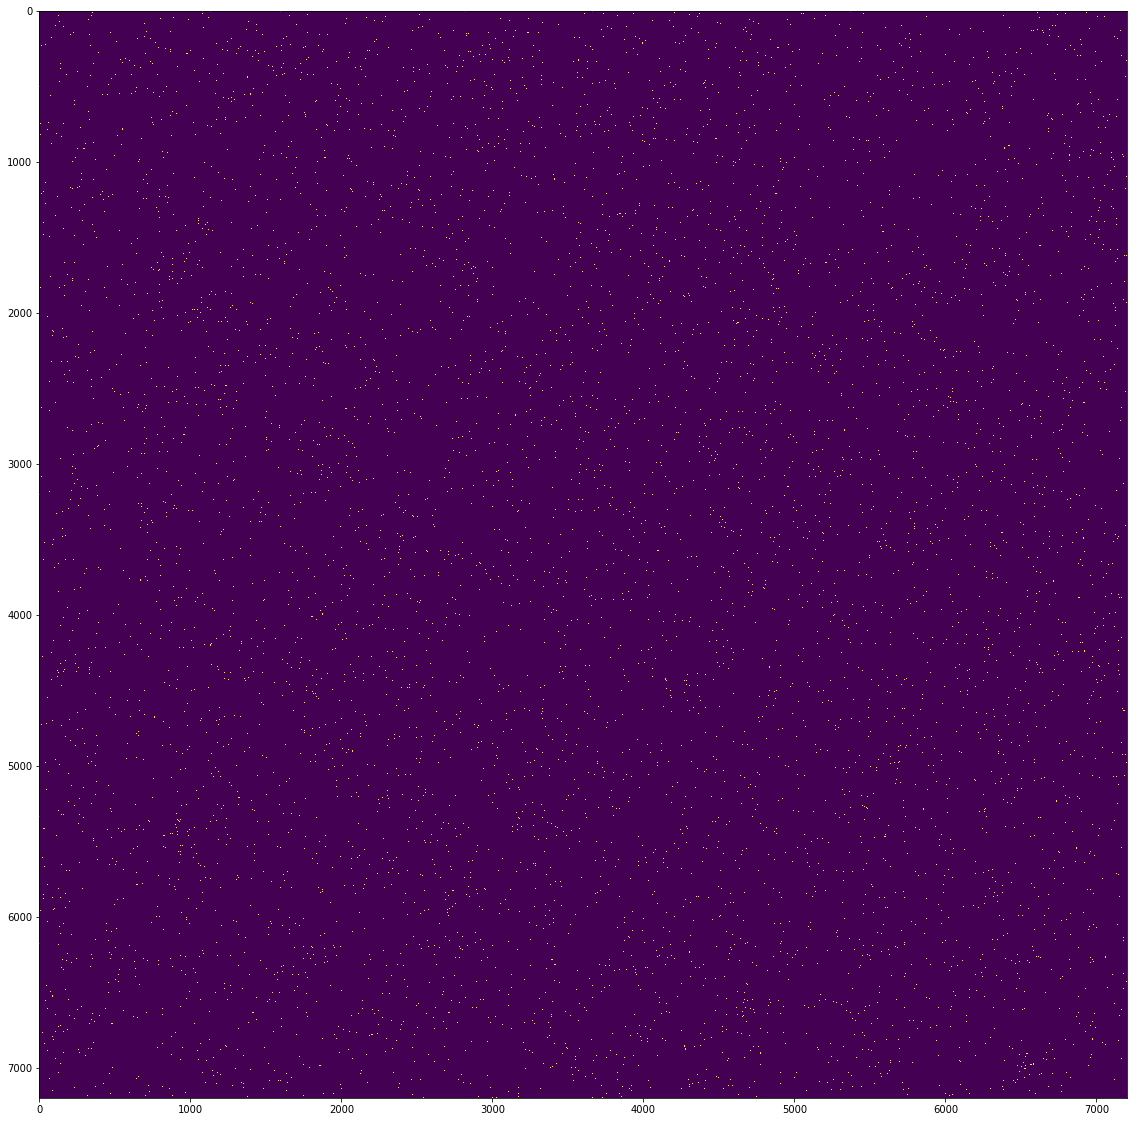

In [16]:
plt.figure(figsize=[20, 20])
plt.imshow(img>0)